In [23]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
from torch_geometric.data import HeteroData

In [24]:
# Using GPU?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [25]:
music = pd.read_csv("music.csv")
music.head()

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [26]:
print(music.shape[0])
music.info()

10000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist.hotttnesss          10000 non-null  float64
 1   artist.id                  10000 non-null  object 
 2   artist.name                10000 non-null  object 
 3   artist_mbtags              3711 non-null   object 
 4   artist_mbtags_count        10000 non-null  float64
 5   bars_confidence            10000 non-null  float64
 6   bars_start                 10000 non-null  float64
 7   beats_confidence           10000 non-null  float64
 8   beats_start                10000 non-null  float64
 9   duration                   10000 non-null  float64
 10  end_of_fade_in             10000 non-null  float64
 11  familiarity                9996 non-null   float64
 12  key                        10000 non-null  float64
 13  key_confidence             10000 non-null

### Data Cleaning

In [27]:
print(music[music.isna().any(axis=1)].shape[0])
music[music.isna().any(axis=1)].head(5)

7717


,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [28]:
music = music.drop(columns=['artist_mbtags','song.hotttnesss'])
music[music.isna().any(axis=1)]

,artist.hotttnesss,artist.id,artist.name,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
752,0.000000,ARVNIVQ1250941026F,Dylan Kuo,0.00000,0.30600,1.59658,0.872,0.39238,230.29506,0.289,...,221.304,0.73700,0.39238,100.173,NaN,0.0,4.000,0.531,Ji Xiang Yan Chu,0
1004,0.384203,AR2D6TV1187B9B2FBF,FIR,0.00000,0.10300,0.09522,0.000,0.09522,206.57587,0.000,...,191.199,0.37400,0.09522,122.041,NaN,0.0,3.000,0.656,Lydia [Piano Version],0
2835,0.420703,ARDXGVT124207832C0,Twinkle Twinkle Little Rock Star,0.00000,0.58600,0.36694,0.495,0.36694,235.38893,0.000,...,228.095,0.99900,0.36694,85.508,NaN,0.0,3.000,1.000,Jamming,0
2950,0.420703,ARDXGVT124207832C0,Twinkle Twinkle Little Rock Star,0.00000,0.15900,0.75800,0.673,0.75800,238.52363,0.000,...,229.866,0.50300,0.38939,80.003,NaN,0.0,4.000,0.000,A Dustland Fairytale,0
3064,0.000000,ARKWXGS11F4C8419B7,Jesus Otero - Luny Tunes,0.00000,0.00300,1.35586,0.594,0.71580,191.76444,0.000,...,191.764,0.30200,0.23364,96.024,requiem,1.0,4.000,0.698,Nivel De Mafia,0
3610,0.000000,ARPWMGF1269FB25878,Yiannis Tassios,0.00000,0.25900,0.20197,0.136,0.20197,208.11710,0.000,...,203.848,0.88000,0.04342,190.035,greek,1.0,4.000,0.978,Ti Patheno,0
4381,0.000000,AROHUUU1269FB35937,Melanie And The Secret Army,0.00000,0.20900,0.83845,0.790,0.40411,255.58159,0.559,...,247.049,0.41400,0.19324,144.319,oi,1.0,4.000,0.386,Held Der Tastatur,0
6348,0.304246,AR7QL2911C8A416805,GAPteborgs Symfoniker / Neeme JA$?rvi,8.85524,8.85524,1.00000,0.000,-60.00000,22050.00000,0.000,...,-21.394,9.22756,0.00000,1.000,Russian Easter Festival_ Overture_ Op.36,2239217.0,0.428,898.891,94496,0
6763,0.284359,ARLOVHG1187FB39692,SA(c)bastien Roch,0.00000,0.08300,0.23377,0.932,0.23377,184.08444,5.079,...,175.502,0.40200,0.23377,126.103,french pop,1.0,4.000,0.260,NaN,0
8744,0.000000,AROHUUU1269FB35937,Melanie And The Secret Army,0.00000,0.00200,0.69235,1.000,0.14843,186.14812,0.340,...,180.518,0.44900,0.14843,110.459,oi,1.0,4.000,1.000,All The Lessons,0


In [29]:
music = music.dropna()
music[music.isna().any(axis=1)]
print(music.shape[0])
music.describe()

9989


,artist.hotttnesss,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,end_of_fade_in,familiarity,key,...,mode_confidence,release.id,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms_freq,time_signature,time_signature_confidence,year
count,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,...,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000,9989.000000
mean,0.385795,0.524377,0.238799,1.065584,0.614011,0.434599,238.467081,0.756694,0.565595,5.277005,...,0.477849,370959.001702,229.934028,0.506941,0.299981,122.914981,0.969179,3.564521,0.509906,935.733907
std,0.143408,0.880489,0.275170,1.724314,0.322405,0.533870,113.999888,1.859318,0.160099,3.553675,...,0.191156,236653.830171,112.052246,0.320806,0.511181,35.187799,0.049379,1.266844,0.373432,996.716226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.044440,0.000000,0.000000,0.000000,...,0.000000,63.000000,1.044000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.325736,0.000000,0.035000,0.441730,0.410000,0.194660,175.986490,0.000000,0.467759,2.000000,...,0.360000,172858.000000,168.855000,0.237000,0.110710,96.967000,0.947629,3.000000,0.097000,0.000000
50%,0.380756,0.000000,0.120000,0.785640,0.686000,0.332560,223.059140,0.199000,0.563750,5.000000,...,0.487000,333103.000000,213.879000,0.500000,0.191490,120.160000,0.999973,4.000000,0.551000,0.000000
75%,0.454160,1.000000,0.351000,1.224300,0.882000,0.500760,276.375060,0.421000,0.668020,8.000000,...,0.606000,573496.000000,266.304000,0.774000,0.294740,144.005000,1.000000,4.000000,0.864000,2000.000000
max,1.082503,9.000000,1.000000,59.743540,1.000000,12.245830,1819.767710,43.119000,1.000000,11.000000,...,1.000000,823599.000000,1813.426000,1.000000,12.245830,262.828000,1.000000,7.000000,1.000000,2010.000000


In [30]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 9999
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   artist.hotttnesss          9989 non-null   float64
 1   artist.id                  9989 non-null   object 
 2   artist.name                9989 non-null   object 
 3   artist_mbtags_count        9989 non-null   float64
 4   bars_confidence            9989 non-null   float64
 5   bars_start                 9989 non-null   float64
 6   beats_confidence           9989 non-null   float64
 7   beats_start                9989 non-null   float64
 8   duration                   9989 non-null   float64
 9   end_of_fade_in             9989 non-null   float64
 10  familiarity                9989 non-null   float64
 11  key                        9989 non-null   float64
 12  key_confidence             9989 non-null   float64
 13  latitude                   9989 non-null   float64
 1

### Model Selection

In [31]:
drop_cols = ['artist.id', 'artist.name', 'location', 'release.id', 'release.name', 
             'similar', 'song.id', 'title']
music_numeric = music.drop(columns=drop_cols)

In [32]:
# encode terms to numeric
label_encoder = LabelEncoder()
music_numeric['terms'] = label_encoder.fit_transform(music_numeric['terms'])

X_numeric = music_numeric.drop(columns=['terms'])
y_numeric = music_numeric['terms']

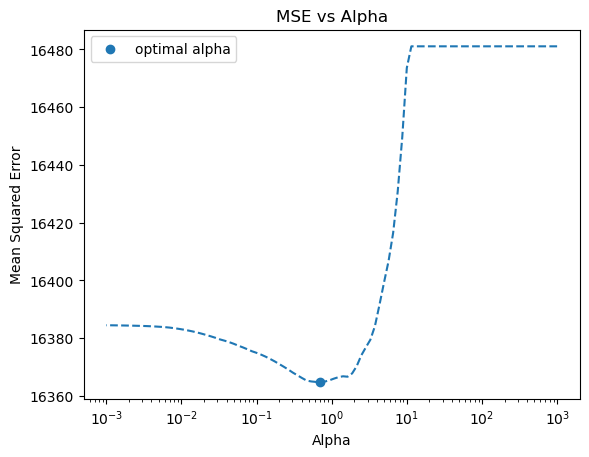

Optimal alpha (Lasso): 0.7054802310718645


In [33]:
X_train, X_test , y_train, y_test = train_test_split(X_numeric, y_numeric, test_size=0.3, random_state=1)

# Fit the transformer only on the training set 
transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)

# Range of alphas (follow log: 0.001 - 1000 normally)
alphas = np.logspace(-3, 3, 100)

# Lasso Cross-validation, 10 folds
lassocv = LassoCV(cv=10, 
                  alphas=alphas, 
                  max_iter=10000, 
                  tol=1e-4, 
                  random_state=404)
lassocv.fit(X_train_norm, y_train)

# mean MSE across folds for each alpha
mse_mean = np.mean(lassocv.mse_path_, axis=1)

# MSE versus alphas
plt.plot(lassocv.alphas_, mse_mean, linestyle='--')
plt.scatter(lassocv.alpha_, mse_mean[np.argmin(mse_mean)], label='optimal alpha')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Alpha')
plt.legend()
plt.show()

print('Optimal alpha (Lasso):', lassocv.alpha_)

In [34]:
# Lasso Coefficients
lasso_coefficients = pd.DataFrame({
    'feature': X_numeric.columns,
    'coefficient': lassocv.coef_
})

nonzero_features = lasso_coefficients[lasso_coefficients['coefficient'] != 0]
nonzero_features

,feature,coefficient
0,artist.hotttnesss,-1.236136
1,artist_mbtags_count,-0.850348
2,bars_confidence,-1.809927
4,beats_confidence,-0.706305
5,beats_start,-0.034632
7,end_of_fade_in,-1.682798
8,familiarity,-1.357662
11,latitude,-9.717912
12,longitude,0.208290
13,loudness,-0.859136


### Logistic Regression (Baseline)

In [35]:
select_col = lasso_coefficients[lasso_coefficients['coefficient'] != 0]['feature'].to_list()
X = music_numeric[select_col]
y = music_numeric['terms']

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

transformer = StandardScaler().fit(X_train)
X_train_norm = pd.DataFrame(transformer.transform(X_train), columns = X_train.columns)

# Apply the same transformation to the testing set
X_test_norm = transformer.transform(X_test)

log_reg = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_norm, y_train)
log_reg.predict_proba(X_test_norm)

/mnt/home/vuninh/miniconda3/envs/CSE404_h200/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[1.62790061e-04, 7.48894304e-04, 4.98562267e-04, ...,
        3.96785275e-03, 7.42952207e-05, 1.24423425e-02],
       [6.39193533e-06, 9.47124743e-06, 1.85472154e-05, ...,
        3.50241291e-04, 6.02675157e-05, 1.56387388e-04],
       [2.09311969e-05, 2.92430621e-05, 1.59444251e-04, ...,
        1.86571306e-05, 6.70987766e-07, 6.70234394e-09],
       ...,
       [1.65954941e-05, 7.20954277e-03, 4.22706078e-05, ...,
        4.93494708e-03, 4.47951958e-06, 4.59980146e-06],
       [9.20068262e-04, 4.38385301e-07, 4.17331707e-04, ...,
        9.49163812e-08, 2.95652178e-06, 3.68805584e-07],
       [1.83939523e-05, 2.24344083e-04, 1.18831587e-03, ...,
        3.82711447e-05, 1.68106489e-05, 3.91682618e-04]],
      shape=(2997, 439))

---

#### Graph Neural Networks

##### Graph Structure

<div>
<img src="media/graph.jpg" width="500"/>
</div>

In [36]:
# These will be the three key identifiers
song_id_map = {sid: i for i, sid in enumerate(list(music['song.id']))}                  # There can only be one song
artist_id_map = {aid: i for i, aid in enumerate(list(music['artist.id'].unique()))}     # They can be under the same artist
release_id_map = {aid: i for i, aid in enumerate(list(music['release.id'].unique()))}   # They can be under the same release

# Tags
tag_id_map = {tid: i for i, tid in enumerate(list(music['terms'].unique()))}

In [37]:
### SONG NODE ###
song_features = ['bars_confidence', 'bars_start', 'beats_confidence', 'beats_start',
    'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness',
    'mode', 'mode_confidence', 'start_of_fade_out', 'tatums_confidence',
    'tatums_start', 'tempo', 'time_signature', 'time_signature_confidence']

num_songs = len(music['song.id'])
num_song_feats = len(song_features)
song_x = np.zeros((num_songs, num_song_feats), dtype=np.float32)

for i, sid in enumerate(music['song.id']):
    row = music.loc[music['song.id'] == sid].iloc[0]
    song_x[i] = row[song_features].values
    
song_x = torch.tensor(song_x, dtype=torch.float32)

In [38]:
### ARTIST NODE ###
artist_features = ['artist.hotttnesss', 'artist_mbtags_count', 'familiarity']
artist_ids = music['artist.id'].unique()
num_artists = len(artist_ids)
artist_x = np.zeros((num_artists, len(artist_features)), dtype=np.float32)

for i, aid in enumerate(artist_ids):
    rows = music[music['artist.id'] == aid].iloc[0]
    artist_x[i] = rows[artist_features].values

artist_x = torch.tensor(artist_x, dtype=torch.float32)

In [39]:
### RELEASE NODE ###
num_releases = len(music['release.id'].unique())
release_x = torch.zeros((num_releases, 1), dtype=torch.float32)

num_tags = len(music['terms'].unique())
tag_x = torch.zeros((num_tags, 1), dtype=torch.float32)

In [40]:
### BUILD EDGES ###

# First row is source idx (song)
# Second row is the destination (artist)

# Song -----> Artist
song_src = []
artist_dst = []

for idx, row in music.iterrows():
    s_id = row['song.id']
    a_id = row['artist.id']
    s_idx = song_id_map[s_id]
    a_idx = artist_id_map[a_id]

    song_src.append(s_idx)
    artist_dst.append(a_idx)

song_artist_edge_index = torch.tensor([song_src, artist_dst], dtype=torch.long)

In [41]:
# Song -----> Release
song_src = []
release_dst = []

for idx, row in music.iterrows():
    s_id = row['song.id']
    r_id = row['release.id'] 
    s_idx = song_id_map[s_id]
    r_idx = release_id_map[r_id]
    song_src.append(s_idx)
    release_dst.append(r_idx)

song_release_edge_index = torch.tensor([song_src, release_dst], dtype=torch.long)


In [42]:
# Song -----> Tag

song_src = []
tag_dst = []
song_tag_weights = []

for idx, row in music.iterrows():
    s_id = row['song.id']
    s_idx = song_id_map[s_id]
    
    tag = row['terms']
    freq = row['terms_freq']

    t_idx = tag_id_map[tag]
    
    song_src.append(s_idx)
    tag_dst.append(t_idx)
    song_tag_weights.append(freq)

song_tag_edge_index = torch.tensor([song_src, tag_dst], dtype=torch.long)
song_tag_edge_attr = torch.tensor(song_tag_weights, dtype=torch.float32)

In [43]:
# Put in HeteroData
data = HeteroData()

# Assign node features
data['song'].x = song_x
data['artist'].x = artist_x
data['release'].x = release_x
data['tag'].x = tag_x

# Assign edges
data['song', 'performed_by', 'artist'].edge_index = song_artist_edge_index
data['song', 'released_on', 'release'].edge_index = song_release_edge_index
data['song', 'has_tag', 'tag'].edge_index = song_tag_edge_index
data['song', 'has_tag', 'tag'].edge_attr = song_tag_edge_attr


In [44]:
data

HeteroData(
  song={ x=[9989, 17] },
  artist={ x=[3880, 3] },
  release={ x=[8107, 1] },
  tag={ x=[457, 1] },
  (song, performed_by, artist)={ edge_index=[2, 9989] },
  (song, released_on, release)={ edge_index=[2, 9989] },
  (song, has_tag, tag)={
    edge_index=[2, 9989],
    edge_attr=[9989],
  }
)